# 10-1. 프로젝트: 인물 모드 문제점 찾기

In [35]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt


(500, 892, 3)


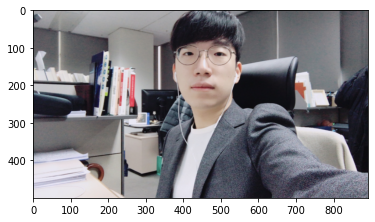

In [36]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) #이미지 불러오기 default channel = BGR

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [37]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f8426e447f0>)

In [7]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'airoplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [38]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [41]:
segvalues, output = model.segmentAsPascalvoc(img_path) 
# segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 
#입력으로는 경로를 입력해야함
#분할 은 pacalvoc 데이터로 학습된 모델을 이용
# segvalues=output 설명, output=이미지

In [ ]:
#pixelLAB에서 만든 색상표
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift # 비트연산자
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

In [54]:
def image_segment(img, path, model, label_num=0):# 특정 클래스 한 종류만 검출하는 방식으로 진행
    segvalues, output = model.segmentAsPascalvoc(img_path) 
    print(f"출력이미지 크기={output.shape}")
    
    for class_id in segvalues['class_ids']: #검출된 클래스들
        print(LABEL_NAMES[class_id])
        
    seg_color = (colormap[label_num][2], colormap[label_num][1], colormap[label_num][0]) # rgb -> bgr
    seg_map = np.all(output==seg_color, axis=-1) 
     # 특정 축 기준 output 이미지가 seg_color(label 색상)랑 같을 때 true false 반환

    img_mask = seg_map.astype(np.uint8) * 255#img_mask 그레이스케일
    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)#3채널로 변환
    img_color_seg = cv2.addWeighted(img, 0.6, color_mask, 0.4, 0.0)#색상으로 클래스 구분

    
    img_orig_blur = cv2.blur(img, (13,13))#13*13 전체이미지에 마스크로 블러 효과 주기

    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)#
    img_bg_mask = cv2.bitwise_not(img_mask_color)# cv2.bitwise_not(): 이미지 반전(2진수변환 후 비트연산)

    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
    # 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) #겹치는 부분 반환
    img_concat = np.where(img_bg_mask==0,img,img_bg_blur)
    
    return output, color_mask, img_color_seg, img_concat # 전체 세그멘테이션 이미지, 지정한 클래스 검색 이미지 2장, 최종블러이미지
    
    

In [55]:
output, color_mask, img_color_seg, img_concat = image_segment(img_orig, img_path, model, 15)# 15 인덱스 사람

출력이미지 크기=(500, 892, 3)
background
chair
person


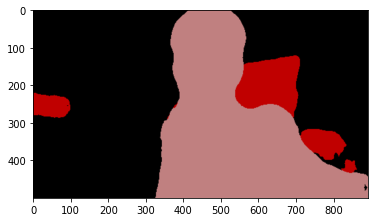

In [60]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.show()

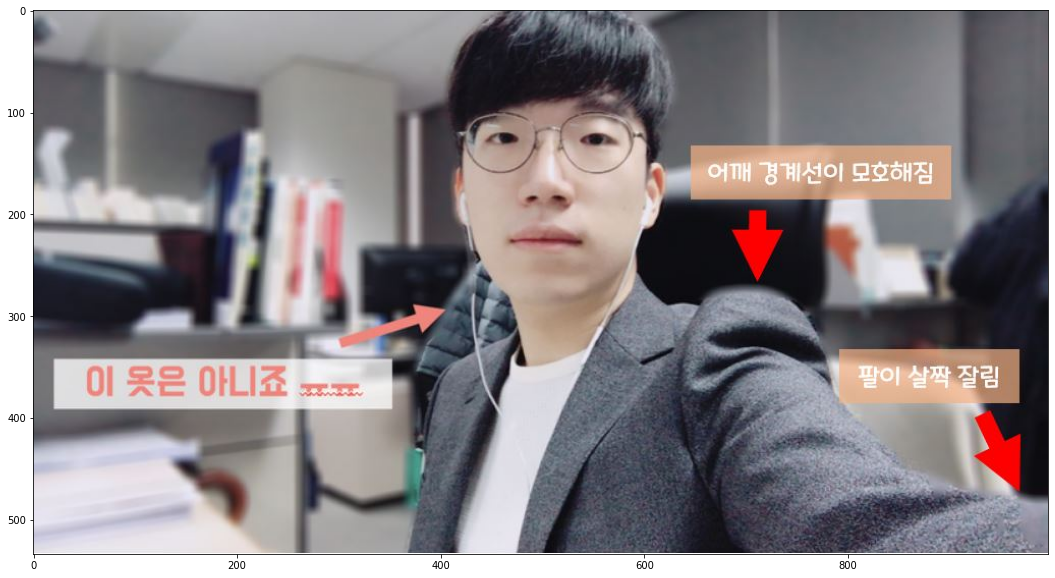

In [85]:
img_err = cv2.imread(os.getcwd()+'/data/human_err.JPG') #이미지 불러오기 default channel = BGR
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img_err, cv2.COLOR_BGR2RGB))
plt.show()
#문제점 서술은 맨아래에

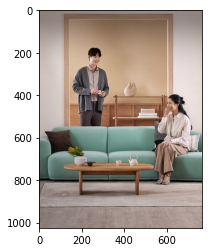

In [63]:
img_path=os.getcwd()+'/data/sofa.jpg'
sofa = cv2.imread(img_path) #이미지 불러오기 default channel = BGR
plt.imshow(cv2.cvtColor(sofa, cv2.COLOR_BGR2RGB))
plt.show()

In [64]:
output, color_mask, img_color_seg, img_concat = image_segment(sofa, img_path, model, 18)# 15 인덱스 사람

출력이미지 크기=(1025, 767, 3)
background
person
pottedplant
sofa


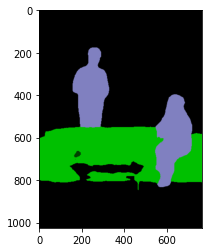

In [65]:
plt.imshow(output)
plt.show()

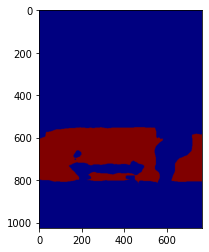

In [66]:
plt.imshow(cv2.cvtColor(color_mask, cv2.COLOR_BGR2RGB))
plt.show()

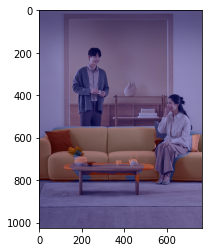

In [67]:
plt.imshow(cv2.cvtColor(img_color_seg, cv2.COLOR_BGR2RGB))
plt.show()

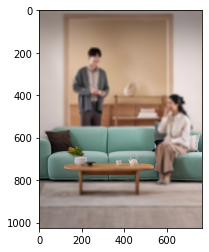

In [68]:
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

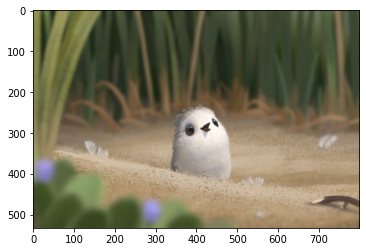

In [69]:
img_path=os.getcwd()+'/data/bird.jpg'
sofa = cv2.imread(img_path) #이미지 불러오기 default channel = BGR
plt.imshow(cv2.cvtColor(sofa, cv2.COLOR_BGR2RGB))
plt.show()

In [83]:
output, color_mask, img_color_seg, img_concat = image_segment(sofa, img_path, model, 3)# 15 인덱스 사람

출력이미지 크기=(533, 800, 3)
background
bird


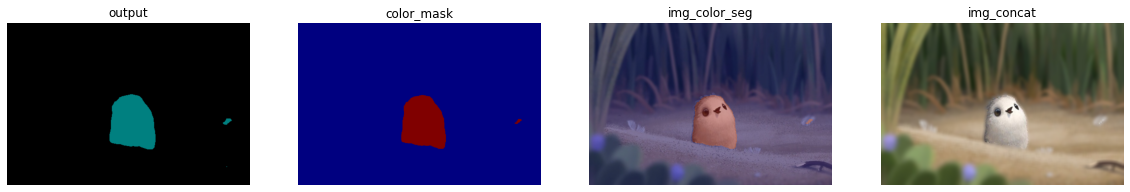

In [84]:
fig=plt.figure(figsize=(20,10))
title=["output","color_mask","img_color_seg","img_concat"]
img=[output, color_mask, img_color_seg, img_concat]
for i in range(4):
    ax=fig.add_subplot(1, 4, i+1)
    if i==0:
        ax.imshow(img[i])
        ax.set_title(title[i])
    else:
        ax.imshow(cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB))
        ax.set_title(title[i])
    ax.axis("off")
        
plt.show()

#  문제점 해결방안 생각해보기

당연하게도 이미지에서 객체 세그멘테이션을 완벽하게 검출하진 못한다.
위에 이미지들 보면 이미지에서 변화량인 큰 에지에 대해서 쉽게 객체에 테두리를 얻을 수 있지만 변화량이 적은 경우에는 분간이 힘든 모습이 보인다. 이를 보완하기 위해서는 이미지에서 depth을 구하여 원본이미지와 같이 학습을 진행한다면 객체간에 구분이 좀 더 명확해질 것 이다. 

이미지에 depth를 구하는 방법을 모색한다면 라이다나 3D카메라와 같은 하드웨어적인 3D 센서를 이용 한다거나 2개의 이미지를 이용하여 시차를 구해 알고리즘 적으로 접근해서 얻는 스테레오 매칭 방식 등 여러 방식이 있다. 단일 이미지에 대해서도 깊이 추정하는 논문도 여럿있다고 들었다.
